# Imports

In [3]:
# Import standard libraries
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pickle
import tqdm
import time

# Import custom libraries
import drugs2
import prizes
import sensitivity_analysis as sensitivity
import sensitivity_sarspartners as svp
import neighborhoods as nbh

# Create prized list

## Select Calu3 differentially expressed genes (with aging information)

In [4]:
# Load Calu3 DE genes data
calu3_de_genes_file_name = '../Data/calu_genes.csv'
calu3_genes_df = pd.read_csv(calu3_de_genes_file_name)

In [5]:
# Minor reformatting
calu3_genes_df.columns = ['name','log2FC_blanco','log2FC_ageing']
calu3_genes_df = calu3_genes_df.replace([np.inf, -np.inf], np.nan)
calu3_genes_df = calu3_genes_df.dropna(subset = ['log2FC_blanco','log2FC_ageing'], how='any')
calu3_genes_df['name'] = calu3_genes_df['name'].str.upper().str.strip()

In [6]:
# Keep only protein coding genes
protein_coding_genes_file_name = '../Data/protein_coding_ensembl_gene_id_hgnc_hg19.txt'
coding_genes = prizes.load_protein_coding_genes(protein_coding_genes_file_name)
calu3_genes_df = calu3_genes_df.merge(coding_genes, on = 'name', how = 'inner')
calu3_genes_df.head()

,name,log2FC_blanco,log2FC_ageing
0,DLGAP5,-1.424971,-0.683937
1,B3GNT7,1.531108,-0.616788
2,POC1A,-0.742422,-0.424127
3,RASA2,0.694723,0.366058
4,WHAMM,0.706843,0.424502


## Create final prized list

In [7]:
terminal_df = calu3_genes_df
terminal_df = terminal_df.loc[terminal_df['log2FC_blanco']*terminal_df['log2FC_ageing']>0]
terminal_df.insert(1,'prize', np.abs(terminal_df['log2FC_blanco']))
terminal_df.head()

,name,prize,log2FC_blanco,log2FC_ageing
0,DLGAP5,1.424971,-1.424971,-0.683937
2,POC1A,0.742422,-0.742422,-0.424127
3,RASA2,0.694723,0.694723,0.366058
4,WHAMM,0.706843,0.706843,0.424502
5,FEN1,0.970364,-0.970364,-0.851541


In [8]:
# Save terminal df to tsv
terminal_df.to_csv(r'../Save_calu3/terminals_ppi_analysis.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Prepare the sentivity analysis for Stein tree parameters

## W range

In [9]:
# Load prizes data
prizes_data = terminal_df
terminals = list(prizes_data['name'])
n_terminals = len(terminals)

In [10]:
# Load IREF interactome
interactome_file = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
graph = oi.Graph(interactome_file)

In [59]:
# Distribution of cheapest path between any two terminals without penalty (g=-\infty)
network = graph.interactome_graph
shortest_dist_mat = np.zeros(shape = (n_terminals,n_terminals))
for ix_prot1 in tqdm.tqdm(np.arange(n_terminals)):
    time.sleep(0.01)
    for ix_prot2 in np.arange(ix_prot1+1, n_terminals, 1):
        shortest_dist_mat[ix_prot1,ix_prot2] = nx.dijkstra_path_length(network,
                                                                       source = terminals[ix_prot1],
                                                                       target = terminals[ix_prot2],
                                                                       weight = 'cost')
        shortest_dist_mat[ix_prot2,ix_prot2] = shortest_dist_mat[ix_prot1,ix_prot2]

100%|██████████| 162/162 [38:54<00:00, 14.41s/it] 


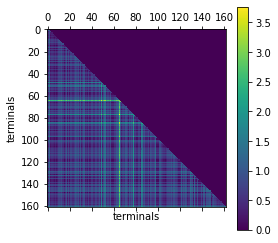

In [63]:
# Plot heatmap of cheapest path
plt.matshow(np.transpose(shortest_dist_mat))
plt.xlabel('terminals')
plt.ylabel('terminals')
plt.colorbar()

Text(0, 0.5, 'Number of pairs of terminals')

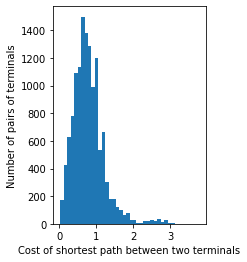

In [64]:
# Plot histogram of cheapest path
plt.subplot(1,2,1)
flat_mat = shortest_dist_mat[np.triu_indices(n_terminals, k=1)]
plt.hist(flat_mat,40)
plt.xlabel('Cost of shortest path between two terminals')
plt.ylabel('Number of pairs of terminals')

## G range

In [11]:
# Create a dictionary containing edge costs under several choices of g
g_range = [0,1,2,3,4,5]
edge_costs_dict={'g = -Inf': graph.edge_costs}
for g in g_range:
    params = {"w": 0, "b": 1, "g": g, "edge_noise": 0, "dummy_mode": "terminals", "seed": 0, "skip_checks": False}
    graph._reset_hyperparameters(params)
    edge_costs_dict['g='+str(g)] = graph.costs
edge_costs_df = pd.DataFrame(data = edge_costs_dict)

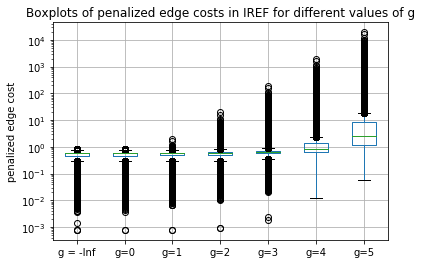

In [12]:
# Boxplot of edge costs under several choices of g
plt.figure()
edge_costs_df.boxplot()
plt.yscale('log')
plt.ylabel('penalized edge cost')
plt.title('Boxplots of penalized edge costs in IREF for different values of g')
plt.show()

## B range

In [13]:
# For a range of g, compute the maximum penalized edge cost
g_range = [0,1,2,3,4,5]
max_penalized_edge_cost = pd.DataFrame(edge_costs_df.max())
max_penalized_edge_cost.columns=['max_penalized_edge_cost']
max_penalized_edge_cost

,max_penalized_edge_cost
g = -Inf,0.859220
g=0,0.860892
g=1,2.015303
g=2,19.487738
g=3,194.212079
g=4,1941.455488
g=5,19413.889586


# Sensitivity analysis for Steiner tree parameters

## Run sensitivity analysis

In [14]:
# Load set of virus interacting genes from Gordon et al.
virus_partners_file_name = "../Data/SARSCov_targets_df.tsv"
virus_interacting_genes = sensitivity.import_virus_partners(virus_partners_file_name)

In [15]:
# Parameters for sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_calu3/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }
# Set sweeping parameters, i.e. configurations (w,b,g)
W_list = np.linspace(start = 0.2, stop = 2, num = 10)
B_list = np.array([5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [42]:
# Run sensitivity analysis
networks_dict = sensitivity.run_sensitivity_analysis(interactome_file_name, 
                                                     prize_file_name, 
                                                     graph_params, 
                                                     W_list, 
                                                     B_list, 
                                                     G=0)

10:05:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:05:55 - OI2: INFO - []
10:05:55 - OI2: INFO - Members of the prize file not present in the interactome:
10:05:55 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.01


10:05:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:05:56 - OI2: INFO - []
10:05:56 - OI2: INFO - Members of the prize file not present in the interactome:
10:05:56 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.02


10:05:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:05:57 - OI2: INFO - []
10:05:57 - OI2: INFO - Members of the prize file not present in the interactome:
10:05:57 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.03


10:05:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:05:58 - OI2: INFO - []
10:05:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:05:58 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.04


10:05:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:05:58 - OI2: INFO - []
10:05:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:05:58 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.05


10:05:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:05:59 - OI2: INFO - []
10:05:59 - OI2: INFO - Members of the prize file not present in the interactome:
10:05:59 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.06


10:06:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:00 - OI2: INFO - []
10:06:00 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:00 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.07


10:06:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:01 - OI2: INFO - []
10:06:01 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:01 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.08


10:06:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:02 - OI2: INFO - []
10:06:02 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:02 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.09


10:06:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:03 - OI2: INFO - []
10:06:03 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:03 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.1


10:06:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:03 - OI2: INFO - []
10:06:03 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:03 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.11


10:06:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:04 - OI2: INFO - []
10:06:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:04 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.12


10:06:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:06 - OI2: INFO - []
10:06:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:06 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.13


10:06:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:07 - OI2: INFO - []
10:06:07 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:07 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.14


10:06:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:08 - OI2: INFO - []
10:06:08 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:08 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.15


10:06:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:09 - OI2: INFO - []
10:06:09 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:09 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.16


10:06:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:10 - OI2: INFO - []
10:06:10 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:10 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.17


10:06:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:11 - OI2: INFO - []
10:06:11 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:11 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.18


10:06:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:12 - OI2: INFO - []
10:06:12 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:12 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.19


10:06:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:13 - OI2: INFO - []
10:06:13 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:13 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.2


10:06:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:14 - OI2: INFO - []
10:06:14 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:14 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.21


10:06:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:15 - OI2: INFO - []
10:06:15 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:15 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.22


10:06:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:16 - OI2: INFO - []
10:06:16 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:16 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.23


10:06:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:17 - OI2: INFO - []
10:06:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:17 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.24


10:06:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:18 - OI2: INFO - []
10:06:18 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:18 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.25


10:06:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:20 - OI2: INFO - []
10:06:20 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:20 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.26


10:06:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:21 - OI2: INFO - []
10:06:21 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:21 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.27


10:06:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:22 - OI2: INFO - []
10:06:22 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:22 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.28


10:06:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:23 - OI2: INFO - []
10:06:23 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:23 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.29


10:06:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:24 - OI2: INFO - []
10:06:24 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:24 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.3


10:06:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:25 - OI2: INFO - []
10:06:25 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:25 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.31


10:06:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:26 - OI2: INFO - []
10:06:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:26 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.32


10:06:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:28 - OI2: INFO - []
10:06:28 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:28 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.33


10:06:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:29 - OI2: INFO - []
10:06:29 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:29 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.34


10:06:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:30 - OI2: INFO - []
10:06:30 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:30 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.35


10:06:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:31 - OI2: INFO - []
10:06:31 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:31 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.36


10:06:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:32 - OI2: INFO - []
10:06:32 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:32 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.37


10:06:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:33 - OI2: INFO - []
10:06:33 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:33 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.38


10:06:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:35 - OI2: INFO - []
10:06:35 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:35 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.39


10:06:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:36 - OI2: INFO - []
10:06:36 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:36 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.4


10:06:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:37 - OI2: INFO - []
10:06:37 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:37 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.41


10:06:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:38 - OI2: INFO - []
10:06:38 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:38 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.42


10:06:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:39 - OI2: INFO - []
10:06:39 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:39 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.43


10:06:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:41 - OI2: INFO - []
10:06:41 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:41 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.44


10:06:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:42 - OI2: INFO - []
10:06:42 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:42 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.45


10:06:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:43 - OI2: INFO - []
10:06:43 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:43 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.46


10:06:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:44 - OI2: INFO - []
10:06:44 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:44 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.47


10:06:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:45 - OI2: INFO - []
10:06:45 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:45 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.48


10:06:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:46 - OI2: INFO - []
10:06:46 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:46 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.49


10:06:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:48 - OI2: INFO - []
10:06:48 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:48 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.5


10:06:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:49 - OI2: INFO - []
10:06:49 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:49 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.51


10:06:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:50 - OI2: INFO - []
10:06:50 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:50 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.52


10:06:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:51 - OI2: INFO - []
10:06:51 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:51 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.53


10:06:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:52 - OI2: INFO - []
10:06:52 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:52 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.54


10:06:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:53 - OI2: INFO - []
10:06:53 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:53 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.55


10:06:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:55 - OI2: INFO - []
10:06:55 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:55 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.56


10:06:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:56 - OI2: INFO - []
10:06:56 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:56 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.57


10:06:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:57 - OI2: INFO - []
10:06:57 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:57 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.58


10:06:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:58 - OI2: INFO - []
10:06:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:58 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.59


10:06:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:06:59 - OI2: INFO - []
10:06:59 - OI2: INFO - Members of the prize file not present in the interactome:
10:06:59 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.6


10:07:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:00 - OI2: INFO - []
10:07:00 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:00 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.61


10:07:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:02 - OI2: INFO - []
10:07:02 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:02 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.62


10:07:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:03 - OI2: INFO - []
10:07:03 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:03 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.63


10:07:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:04 - OI2: INFO - []
10:07:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:04 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.64


10:07:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:05 - OI2: INFO - []
10:07:05 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:05 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.65


10:07:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:06 - OI2: INFO - []
10:07:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:06 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.66


10:07:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:07 - OI2: INFO - []
10:07:07 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:07 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.67


10:07:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:09 - OI2: INFO - []
10:07:09 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:09 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.68


10:07:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:10 - OI2: INFO - []
10:07:10 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:10 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.69


10:07:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:11 - OI2: INFO - []
10:07:11 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:11 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.7


10:07:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:12 - OI2: INFO - []
10:07:12 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:12 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.71


10:07:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:13 - OI2: INFO - []
10:07:13 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:13 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.72


10:07:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:14 - OI2: INFO - []
10:07:14 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:15 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.73


10:07:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:16 - OI2: INFO - []
10:07:16 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:16 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.74


10:07:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:17 - OI2: INFO - []
10:07:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:17 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.75


10:07:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:18 - OI2: INFO - []
10:07:18 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:18 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.76


10:07:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:19 - OI2: INFO - []
10:07:19 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:19 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.77


10:07:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:20 - OI2: INFO - []
10:07:20 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:20 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.78


10:07:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:22 - OI2: INFO - []
10:07:22 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:22 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.79


10:07:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:23 - OI2: INFO - []
10:07:23 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:23 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.8


10:07:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:24 - OI2: INFO - []
10:07:24 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:24 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.81


10:07:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:25 - OI2: INFO - []
10:07:25 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:25 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.82


10:07:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:26 - OI2: INFO - []
10:07:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:26 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.83


10:07:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:27 - OI2: INFO - []
10:07:27 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:27 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.84


10:07:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:29 - OI2: INFO - []
10:07:29 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:29 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.85


10:07:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:30 - OI2: INFO - []
10:07:30 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:30 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.86


10:07:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:31 - OI2: INFO - []
10:07:31 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:31 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.87


10:07:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:32 - OI2: INFO - []
10:07:32 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:32 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.88


10:07:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:33 - OI2: INFO - []
10:07:33 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:33 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.89


10:07:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:34 - OI2: INFO - []
10:07:34 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:34 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.9


10:07:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:36 - OI2: INFO - []
10:07:36 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:36 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.91


10:07:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:37 - OI2: INFO - []
10:07:37 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:37 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.92


10:07:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:38 - OI2: INFO - []
10:07:38 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:38 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.93


10:07:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:39 - OI2: INFO - []
10:07:39 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:39 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.94


10:07:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:40 - OI2: INFO - []
10:07:40 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:40 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.95


10:07:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:42 - OI2: INFO - []
10:07:42 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:42 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.96


10:07:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:43 - OI2: INFO - []
10:07:43 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:43 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.97


10:07:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:44 - OI2: INFO - []
10:07:44 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:44 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.98


10:07:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:45 - OI2: INFO - []
10:07:45 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:45 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.99


10:07:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:07:46 - OI2: INFO - []
10:07:46 - OI2: INFO - Members of the prize file not present in the interactome:
10:07:46 - OI2: INFO - ['AADAT', 'C1ORF53', 'C5ORF56', 'CAPN8', 'FILIP1L', 'HIST1H4E', 'IFI44L', 'KIF18B', 'PDF', 'SLC28A3', 'SMIM4', 'TMEM238', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 1.0


In [43]:
# Save as pickle
with open("../Save_calu3/networks_dict.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [16]:
# Add metatadata
networks_dict = pickle.load(open("../Save_calu3/networks_dict.pkl", "rb"))
networks_dict = sensitivity.add_metadata(networks_dict, virus_interacting_genes)

In [17]:
# Make summary
networks_summary_df = sensitivity.make_summary(networks_dict, n_terminals, g=0)
networks_summary_df.head()

,index,w,b,g,nodes,edges,number_components,size_components,percentage_terminals,upregulated_terminals,downregulated_terminals,number_transcription_regulators,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
w_0.2_b_10.0,1,0.2,10.0,0,263,688,36,"[224, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.938272,103,125,12,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",4,"[FOXRED2, RIPK1, STC2, TMEM97]"
w_0.2_b_15.0,2,0.2,15.0,0,263,688,36,"[224, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.938272,103,125,12,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",4,"[FOXRED2, RIPK1, STC2, TMEM97]"
w_0.2_b_20.0,3,0.2,20.0,0,263,688,36,"[224, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.938272,103,125,12,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",4,"[FOXRED2, RIPK1, STC2, TMEM97]"
w_0.2_b_25.0,4,0.2,25.0,0,263,688,36,"[224, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.938272,103,125,12,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",4,"[FOXRED2, RIPK1, STC2, TMEM97]"
w_0.2_b_30.0,5,0.2,30.0,0,263,688,36,"[224, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0.938272,103,125,12,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",4,"[FOXRED2, RIPK1, STC2, TMEM97]"


## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

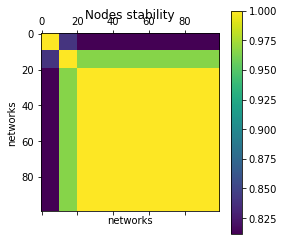

In [46]:
# Stability of selected nodes
mat_allnodes = sensitivity.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

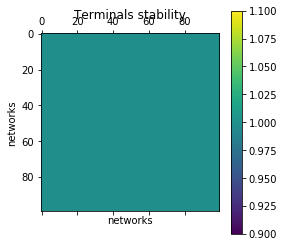

In [47]:
# Stability of selected terminals
mat_terminals = sensitivity.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

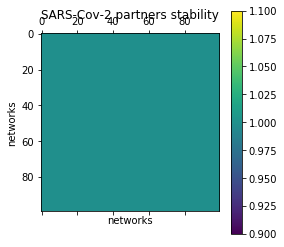

In [48]:
# Stability of selected SARS-Cov-2 partners
mat_sars = sensitivity.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [18]:
# Select network corresponding to g=0, w=1.4 and b=40
index_selected = 67
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected = networks_dict[paramstring_selected]

In [19]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected, filename="../Save_calu3/network_selected.html")
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_calu3/network_selected.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(robust_network, filename= '../Save_calu3/network_selected.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_calu3/network_selected.pickle')

# Sensitivity analysis for virus partners prize

## Run sensitivity analysis

In [51]:
# Identify which SARS-Cov-2 partners are in the terminal list
terminal_partners = set(terminals).intersection(virus_interacting_genes)
print(terminal_partners)

{'STC2', 'FOXRED2', 'TMEM97'}


In [53]:
# Run sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_calu3/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0,
                "w": 1.4,
                "b": 40,
                "g": 0
                }
# List of values of P
P_list = np.arange(0,0.0016,0.0001)

networks_dict = svp.run_prize_sensitivity_analysis(interactome_file_name, 
                                                   prize_file_name, 
                                                   graph_params, 
                                                   virus_interacting_genes, 
                                                   terminal_partners, 
                                                   P_list)

10:17:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:16 - OI2: INFO - []
10:17:16 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:16 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.0625


10:17:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:17 - OI2: INFO - []
10:17:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:17 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.125


10:17:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:19 - OI2: INFO - []
10:17:19 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:19 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.1875


10:17:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:21 - OI2: INFO - []
10:17:21 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:21 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.25


10:17:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:22 - OI2: INFO - []
10:17:22 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:22 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.3125


10:17:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:24 - OI2: INFO - []
10:17:24 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:24 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.375


10:17:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:26 - OI2: INFO - []
10:17:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:26 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.4375


10:17:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:28 - OI2: INFO - []
10:17:28 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:28 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.5


10:17:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:29 - OI2: INFO - []
10:17:29 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:29 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.5625


10:17:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:31 - OI2: INFO - []
10:17:31 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:31 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.625


10:17:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:33 - OI2: INFO - []
10:17:33 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:33 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.6875


10:17:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:34 - OI2: INFO - []
10:17:34 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:34 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.75


10:17:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:36 - OI2: INFO - []
10:17:36 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:36 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.8125


10:17:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:38 - OI2: INFO - []
10:17:38 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:38 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.875


10:17:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:40 - OI2: INFO - []
10:17:40 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:40 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 0.9375


10:17:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:17:41 - OI2: INFO - []
10:17:41 - OI2: INFO - Members of the prize file not present in the interactome:
10:17:41 - OI2: INFO - ['AADAT', 'ATP5MG', 'C1ORF53', 'C5ORF56', 'CAPN8', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'FILIP1L', 'HIST1H4E', 'HS2ST1', 'HS6ST2', 'IFI44L', 'KIF18B', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'PDF', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SLC28A3', 'SMIM4', 'SPART', 'TIMM29', 'TLE5', 'TMEM238', 'TOMM70', 'WASHC4', 'WHAMM', 'ZNF654', 'ZSWIM4']


Progress= 1.0


In [55]:
# Save as pickle
with open("../Save_calu3/networks_dict_sarspartners.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [56]:
# Add metadata
networks_dict = pickle.load(open("../Save_calu3/networks_dict_sarspartners.pkl", "rb"))
networks_dict = svp.add_metadata(networks_dict, virus_interacting_genes)

In [57]:
# Make summary
networks_summary_df = svp.make_summary(networks_dict, n_terminals)
networks_summary_df.head()

,index,p,nodes,edges,number_components,size_components,percentage_terminals,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
p_0.0,0,0.0,324,1385,1,[324],0.938272,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",4,"[FOXRED2, RIPK1, STC2, TMEM97]"
p_0.0001,1,0.0001,323,1367,1,[323],0.938272,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",5,"[EXOSC2, FOXRED2, RIPK1, STC2, TMEM97]"
p_0.0002,2,0.0002,323,1367,1,[323],0.938272,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",5,"[EXOSC2, FOXRED2, RIPK1, STC2, TMEM97]"
p_0.00030000000000000003,3,0.00030000000000000003,324,1395,1,[324],0.938272,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",7,"[CUL2, EXOSC2, FOXRED2, RBX1, RIPK1, STC2, TME..."
p_0.0004,4,0.0004,325,1435,1,[325],0.938272,"[BACH1, BACH2, CREB5, ETV6, IRF2, MAML2, NFE2L...",8,"[CUL2, EXOSC2, FOXRED2, HDAC2, RBX1, RIPK1, ST..."


## Plot number of SARS-Cov-2 partners picked up versus p

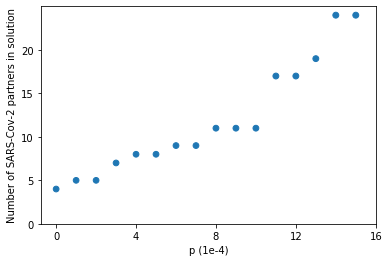

In [58]:
plt.figure()
plt.scatter(x = networks_summary_df['p'], 
            y = networks_summary_df['number_of_proteins_interacting_sars'],
            s = 0.1*networks_summary_df['nodes'])
plt.xlabel('p (1e-4)')
plt.ylabel('Number of SARS-Cov-2 partners in solution')
plt.xticks(np.arange(0,17,4),['0','4','8','12','16'])
plt.yticks(np.arange(0,25,5))
plt.show()

## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

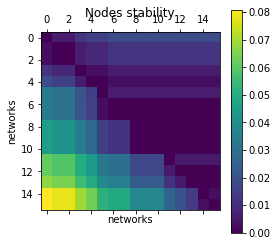

In [59]:
# Stability of selected nodes
mat_allnodes = svp.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

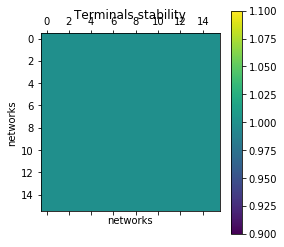

In [60]:
# Stability of selected terminals
mat_terminals = svp.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

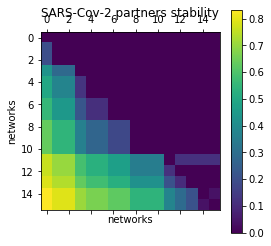

In [61]:
# Stability of selected SARS-Cov-2 partners
mat_sars = svp.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [62]:
# Save network
index_selected = 8
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected2 = networks_dict[paramstring_selected]

In [63]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected2, filename="../Save_calu3/network_selected_sarspartners.html")
oi.output_networkx_graph_as_pickle(network_selected2, filename= '../Save_calu3/network_selected_sarspartners.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(network_selected, filename= r'../Save_calu3/network_selected_sarspartners.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_calu3/network_selected_sarspartners.pickle')

# Add drug targets to selected network

## Construct drug/target data

In [20]:
# Compute degree centrality for all nodes in the interactome
graph = oi.Graph(interactome_file_name)
centrality_dic = nx.degree_centrality(graph.interactome_graph)

In [21]:
# Load drug/target data from DrugCentral
drug_target_file_name = '../Data/drug.target.interaction.tsv'
drugcentral_df = drugs2.load_drug_target_data(drug_target_file_name, aff_cst_thresh=5)
drugcentral_df['degree_centrality'] = [centrality_dic[gene] if (gene in list(centrality_dic.keys())) else None for gene in drugcentral_df['gene']]
drugcentral_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality
0,SCN4A,levobupivacaine,Sodium channel protein type 4 subunit alpha,NaN,NaN,0.000635
1,CYP2D6,levobupivacaine,Cytochrome P450 2D6,6.706859,IC50,NaN
4,PTGER1,levobupivacaine,Prostaglandin E2 receptor EP1 subtype,NaN,NaN,0.000317
5,SCN1A,levobupivacaine,Sodium channel protein type 1 subunit alpha,5.790000,IC50,0.000254
6,KCNA5,levobupivacaine,Potassium voltage-gated channel subfamily A me...,NaN,NaN,0.002031


In [22]:
# Construct table that gives the number of targets per drug
num_targets_df0 = drugcentral_df.groupby('drug', as_index=False)[['gene']].agg({
    ('num_targets','count'),
    ('num_terminal_targets',lambda gs: len(set(gs).intersection(set(terminals))))
})
max_centrality_df0 = drugcentral_df.groupby('drug', as_index=False)[['degree_centrality']].agg({
    ('max_degree_centrality',max)
})
num_targets_df = pd.DataFrame({'drug': num_targets_df0.index,
                               'num_targets': num_targets_df0['gene']['num_targets'],
                               'num_terminal_targets': num_targets_df0['gene']['num_terminal_targets'],
                               'max_target_centrality': max_centrality_df0['degree_centrality']['max_degree_centrality']}).reset_index(drop=True)
num_targets_df = num_targets_df.sort_values(by='num_targets', ascending=False, inplace=False)
num_targets_df.head(10)

,drug,num_targets,num_terminal_targets,max_target_centrality
1830,sunitinib,260,7,0.055718
1369,nintedanib,218,5,0.037187
1269,midostaurin,204,5,0.055718
259,bosutinib,203,3,0.055718
474,crizotinib,148,5,0.055718
1735,ruxolitinib,132,2,0.027224
508,dasatinib,129,4,0.055718
1730,ruboxistaurin,121,2,0.055718
1795,sorafenib,116,5,0.037187
2031,vandetanib,109,2,0.055718


In [25]:
# Load L1000 drugs with correlations
embedded_drugs_file_name = '../Data/calu_correlations_autoencoder_space.txt'
bestdrugs_df = pd.read_csv(embedded_drugs_file_name, header=None)
bestdrugs_df.columns = ['drug','corr']
bestdrugs_df['drug'] = bestdrugs_df['drug'].str.strip("()' ").str.lower()
bestdrugs_df['corr'] = pd.to_numeric(bestdrugs_df['corr'].str.strip("() "))
bestdrugs_df.sort_values(by='corr', axis=0, ascending=False, inplace=True)
bestdrugs_df = bestdrugs_df.iloc[0:141] # so that we have the same number (142) of selected drugs as in the A549-SARS-Cov-2 analysis
bestdrugs_df.head()

,drug,corr
0,indinavir,0.302464
1,zafirlukast,0.298350
2,atorvastatin,0.294954
3,sumatriptan,0.294873
4,lansoprazole,0.294614


In [26]:
# Merge L1000 drugs with DrugCentral drug/target dataset
targets_and_drugs_df = drugcentral_df.merge(bestdrugs_df, on = 'drug', how = 'inner')
targets_and_drugs_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality,corr
0,ADRB1,acebutolol,Beta-1 adrenergic receptor,7.300000,Ki,0.001206,0.274673
1,ADRB2,acebutolol,Beta-2 adrenergic receptor,6.400000,Ki,0.015421,0.274673
2,MAOA,amiloride,Amine oxidase [flavin-containing] A,5.407934,IC50,0.000698,0.273852
3,SCNN1A,amiloride,"Amiloride-sensitive sodium channel, ENaC",6.700000,IC50,0.001333,0.273852
4,SCNN1B,amiloride,"Amiloride-sensitive sodium channel, ENaC",6.700000,IC50,0.001396,0.273852


## Add drug target information to selected network

In [27]:
network_selected = pickle.load(open('../Save_calu3/network_selected.pickle', "rb"))
network_selected = drugs2.add_drug_info_to_selected_network(network_selected, targets_and_drugs_df)
# Save enriched network as pickle
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_calu3/network_selected_with_drug_info.pickle')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_calu3/network_selected_with_drug_info.pickle')

In [28]:
# Construct table of drug targets in the network
drug_targets_df = drugs2.drug_targets_in_selected_network(network_selected)
drug_targets_df.to_csv(r'../Save_calu3/drug_targets_in_network.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
drug_targets_df['affinity'] = pd.to_numeric(drug_targets_df['affinity'], errors='coerce')
drug_targets_df.dropna(subset=['affinity'], inplace=True)
drug_targets_df

,name,protein_target,drug,corr,affinity
ACHE,ACHE,{Acetylcholinesterase},nizatidine,0.27935183,5.250681
ACHE,ACHE,{Acetylcholinesterase},pentoxifylline,0.28606582,5.180000
ADORA2A,ADORA2A,{Adenosine receptor A2a},amiloride,0.273852,5.480000
ADORA2A,ADORA2A,{Adenosine receptor A2a},econazole,0.28886765,5.085868
ADORA2A,ADORA2A,{Adenosine receptor A2a},sildenafil,0.2821101,6.700000
ADORA2A,ADORA2A,{Adenosine receptor A2a},trioxsalen,0.28003362,6.132533
AR,AR,{Androgen receptor},bicalutamide,0.2838195,7.720000
AR,AR,{Androgen receptor},dexamethasone,0.27767324,5.850000
AR,AR,{Androgen receptor},medroxyprogesterone,0.2735338,8.200000
AR,AR,{Androgen receptor},enzalutamide,0.2886959,7.310000


In [29]:
# Save drug/target dataframe to csv
drug_targets_df.to_csv(r'../Save_calu3/final_drug_target_table.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Compare to A549 cell type

In [35]:
# Drug/target dataframe for A549
drug_targets_df_a549_file_name = '../Save/final_drug_target_table.tsv'
drug_targets_df_a549 = pd.read_csv(drug_targets_df_a549_file_name, sep = '\t')
drug_targets_df_a549.head()

,name,protein_target,drug,corr,affinity
0,ACVR2A,{'Activin receptor type-2A'},dasatinib,0.882561,6.68
1,AURKC,{'Aurora kinase C'},erlotinib,0.873780,6.22
2,AURKC,{'Aurora kinase C'},sorafenib,0.865171,6.68
3,AURKC,{'Aurora kinase C'},sunitinib,0.868590,6.66
4,AURKC,{'Aurora kinase C'},pazopanib,0.866959,6.12


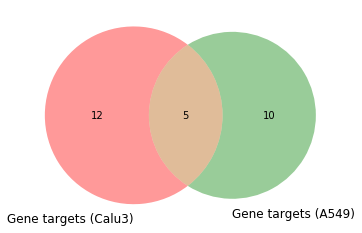

In [31]:
# Common gene targets
targets_calu3 = set(drug_targets_df['name'])
targets_a549 = set(drug_targets_df_a549['name'])
venn2(subsets = [targets_calu3,targets_a549],set_labels = ('Gene targets (Calu3)','Gene targets (A549)'))

             drug  num_targets  num_terminal_targets  max_target_centrality
1830    sunitinib          260                     7               0.055718
259     bosutinib          203                     3               0.055718
1735  ruxolitinib          132                     2               0.027224
508     dasatinib          129                     4               0.055718
1795    sorafenib          116                     5               0.037187
167      axitinib           99                     4               0.055718
719     erlotinib           96                     3               0.055718
991      imatinib           70                     0               0.055718
1938  tofacitinib           43                     0               0.020434
43       afatinib           38                     1               0.055718
2063   vorinostat           32                     0               0.030334
615     docetaxel           15                     0               0.055718
2032   varde

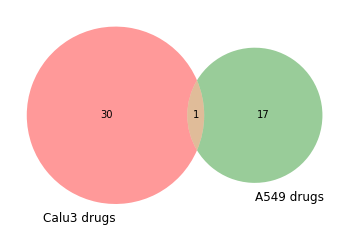

In [33]:
# Common drugs (note that all 5 genes in the intersection are targeted by pazopanib)
drugs_calu3 = set(drug_targets_df['drug'])
drugs_a549 = set(drug_targets_df_a549['drug'])
venn2(subsets = [drugs_calu3,drugs_a549],set_labels = ('Calu3 drugs','A549 drugs'))

a549_minus_calu3 = num_targets_df.loc[num_targets_df['drug'].isin(drugs_a549.difference(drugs_calu3))]
calu3_minus_a549 = num_targets_df.loc[num_targets_df['drug'].isin(drugs_calu3.difference(drugs_a549))]
a549_inter_calu3 = num_targets_df.loc[num_targets_df['drug'].isin(drugs_a549.intersection(drugs_calu3))]
print(a549_minus_calu3)
print(calu3_minus_a549)
print(a549_inter_calu3)